In [1]:
from rl4fisheries import Msy, ConstEsc, CautionaryRule, AsmEnv

In [2]:
import pandas as pd
import numpy as np

In [3]:
cr_gp = {'radius': 0.2195, 'theta': 0.4433, 'y2': 0.4106}
cr_gp_args = {}
cr_gp_args['x1'] = cr_gp['radius'] * np.sin(cr_gp['theta'])
cr_gp_args['x2'] = cr_gp['radius'] * np.cos(cr_gp['theta'])
cr_gp_args['y2'] = cr_gp['y2']

cr_gbrt = {'radius': 0.3724, 'theta':0.4228, 'y2':0.4207}
cr_gbrt_args = {}
cr_gbrt_args['x1'] = cr_gbrt['radius'] * np.sin(cr_gbrt['theta'])
cr_gbrt_args['x2'] = cr_gbrt['radius'] * np.cos(cr_gbrt['theta'])
cr_gbrt_args['y2'] = cr_gbrt['y2']

msy_gp_args = {'mortality': 0.0368}
msy_gbrt_args = {'mortality': 0.0261}

esc_gp_args = {'escapement': 0.1718}
esc_gbrt_args = {'escapement': 0.1596}

In [4]:
env = AsmEnv(config = {'s':0.97})

In [5]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

cr_gp_pol = CautionaryRule(env, **cr_gp_args)
esc_gp_pol = ConstEsc(env, **esc_gp_args)
msy_gp_pol = Msy(env, **msy_gp_args)

cr_gbrt_pol = CautionaryRule(env, **cr_gbrt_args)
esc_gbrt_pol = ConstEsc(env, **esc_gbrt_args)
msy_gbrt_pol = Msy(env, **msy_gbrt_args)

# Policy plots

In [53]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=100):
    obs_list = np.linspace(minx, maxx, nx)
    return pd.DataFrame(
        {
            'obs': obs_list,
            'pop': (obs_list + 1)/2,
            'pol': [policy_obj.predict(obs)[0][0] for obs in obs_list]
        }
    )

In [20]:
cr_gbrt_df = get_policy_df(CautionaryRule(env, **cr_gbrt_args))
cr_gp_df = get_policy_df(CautionaryRule(env, **cr_gp_args))

(<Axes: title={'center': 'Cautionary Rule GP policy'}, xlabel='pop'>,
 <Axes: title={'center': 'Cautionary Rule GBRT policy'}, xlabel='pop'>)

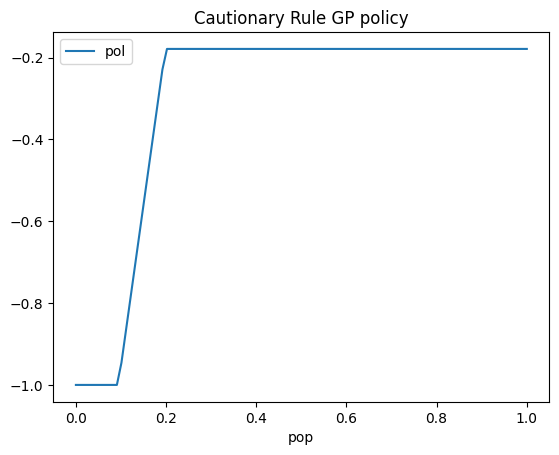

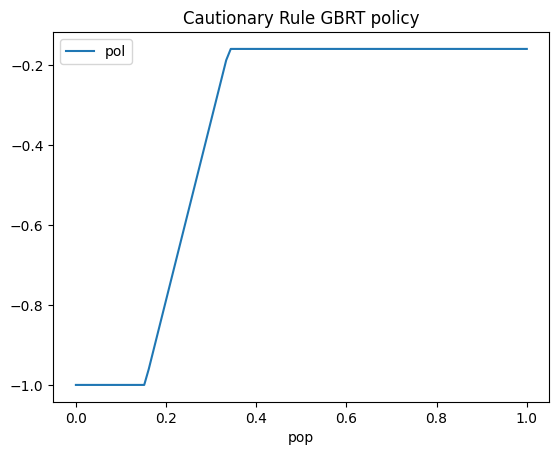

In [21]:
(
    cr_gp_df.plot(x='pop', y='pol', title='Cautionary Rule GP policy'),
    cr_gbrt_df.plot(x='pop', y='pol', title='Cautionary Rule GBRT policy'),
)    

In [24]:
esc_gbrt_df = get_policy_df(ConstEsc(env, **esc_gbrt_args))
esc_gp_df = get_policy_df(ConstEsc(env, **esc_gp_args))

(<Axes: title={'center': 'Constant Escapement GP policy'}, xlabel='pop'>,
 <Axes: title={'center': 'Constant Escapement GBRT policy'}, xlabel='pop'>)

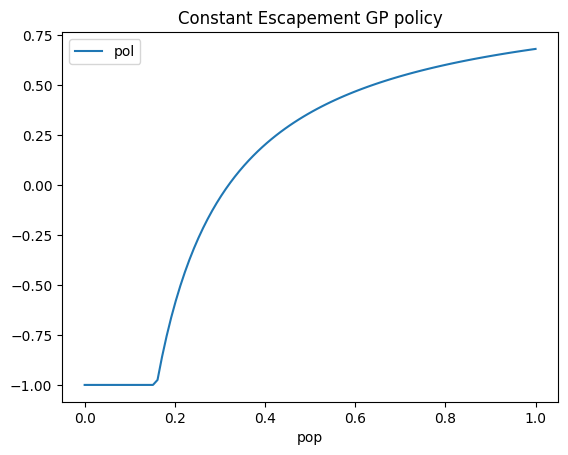

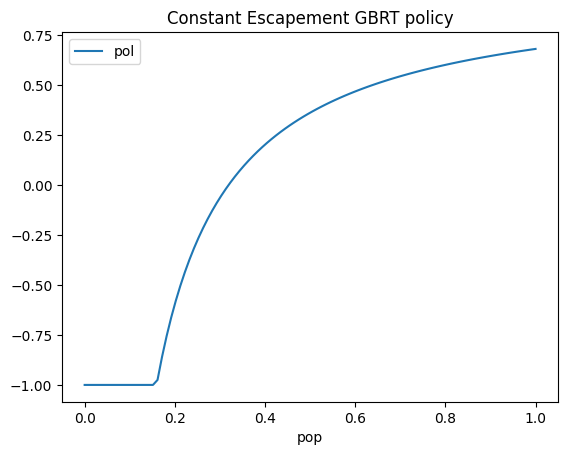

In [25]:
(
    esc_gbrt_df.plot(x='pop', y='pol', title='Constant Escapement GP policy'),
    esc_gbrt_df.plot(x='pop', y='pol', title='Constant Escapement GBRT policy')
)

## PPO policy

In [9]:
from stable_baselines3 import PPO
ppoAgent = PPO.load("../saved_agents/PPO-AsmEnv-2obs-1M.zip")
ppoAgent_2 = PPO.load("../saved_agents/PPO-AsmEnv-2obs-1M-v2.zip")

In [ ]:
def GaussianProcessPolicy(policy_df, length_scale=10, noise_level=0.1):
    """
    policy_df.columns = [X, Y, Z, act_x, act_y]
                    -> action (act_x, act_y) taken at point (X, Y, Z)
    """
    predictors = policy_df[["X", "Y", "Z"]].to_numpy()
    targets = policy_df[["act_x", "act_y"]].to_numpy()
    kernel = (
    1.0 * RBF(length_scale = length_scale) 
    + WhiteKernel(noise_level=noise_level)
    )
    print("Fitting Gaussian Process...")
    gpp = (
    GaussianProcessRegressor(kernel=kernel, random_state=0)
    .fit(predictors, targets)
    )
    print("Done fitting Gaussian Process...")
    return gpp

In [54]:
ppo_df = get_policy_df(ppoAgent)
ppo_2_df = get_policy_df(ppoAgent_2)

ValueError: Error: Unexpected observation shape () for Box environment, please use (2,) or (n_env, 2) for the observation shape.

# Reward distributions

In [73]:
cr_gp_rews = evaluate_policy(cr_gp_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]
cr_gbrt_rews = evaluate_policy(cr_gbrt_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]
print("done with CR.")

esc_gp_rews = evaluate_policy(esc_gp_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]
esc_gbrt_rews = evaluate_policy(esc_gbrt_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]
print("done with Esc")

msy_gp_rews = evaluate_policy(msy_gp_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]
msy_gbrt_rews = evaluate_policy(msy_gbrt_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]
print("done with MSY")

ppo_rews = evaluate_policy(ppoAgent, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]
ppo_rews_2 = evaluate_policy(ppoAgent_2, Monitor(env), return_episode_rewards=True, n_eval_episodes=300)[0]

done with CR.
done with Esc
done with MSY


In [65]:
rew_df = pd.DataFrame({
    'CautionaryRule_gp': cr_gp_rews,
    'CautionaryRule_gbrt': cr_gbrt_rews,
    'Escapement_gp': esc_gp_rews,
    'Escapement_gbrt': esc_gbrt_rews,
    'MSY_gp': msy_gp_rews,
    'MSY_gbrt': msy_gbrt_rews,
    'PPO': ppo_rews,
    '2_PPO': ppo_rews_2,
}).melt()

In [66]:
name_transforms = {'gp': 'gp', 'rt':'gbrt', 'PO':'ppo'}
rew_df['optimization'] = rew_df.apply(lambda row: name_transforms[row.variable[-2:]], axis=1)
rew_df.head()

,variable,value,optimization
0,CautionaryRule_gp,304.364097,gp
1,CautionaryRule_gp,306.663687,gp
2,CautionaryRule_gp,302.857712,gp
3,CautionaryRule_gp,301.917373,gp
4,CautionaryRule_gp,301.645522,gp


In [67]:
from plotnine import ggplot, aes, geom_density

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


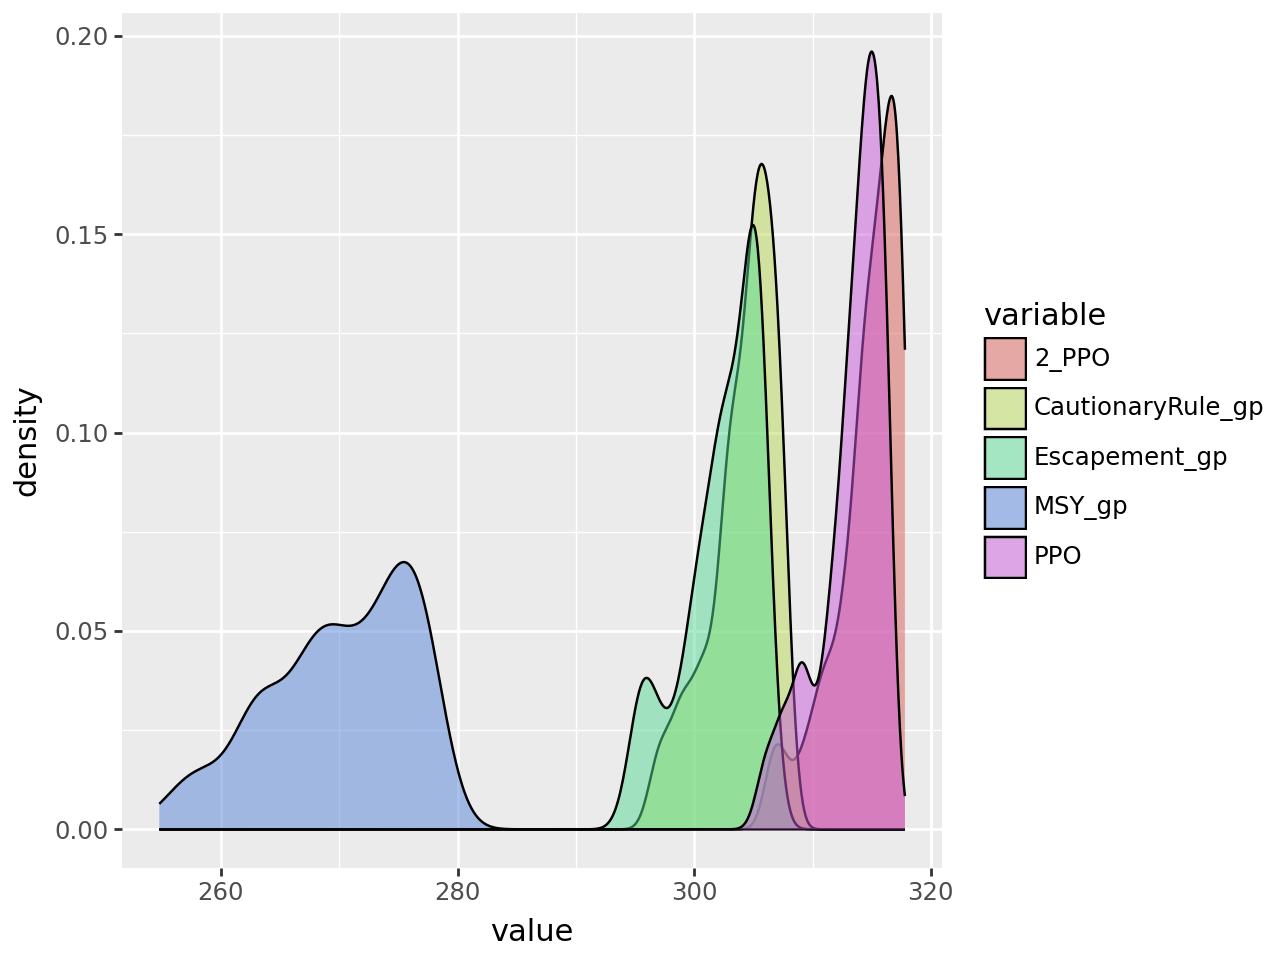

(<Figure Size: (640 x 480)>,)

In [68]:
ggplot(rew_df[(rew_df["optimization"] == 'gp') | (rew_df["optimization"] == 'ppo')], aes(x='value', fill='variable')) + geom_density(alpha=0.5),

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


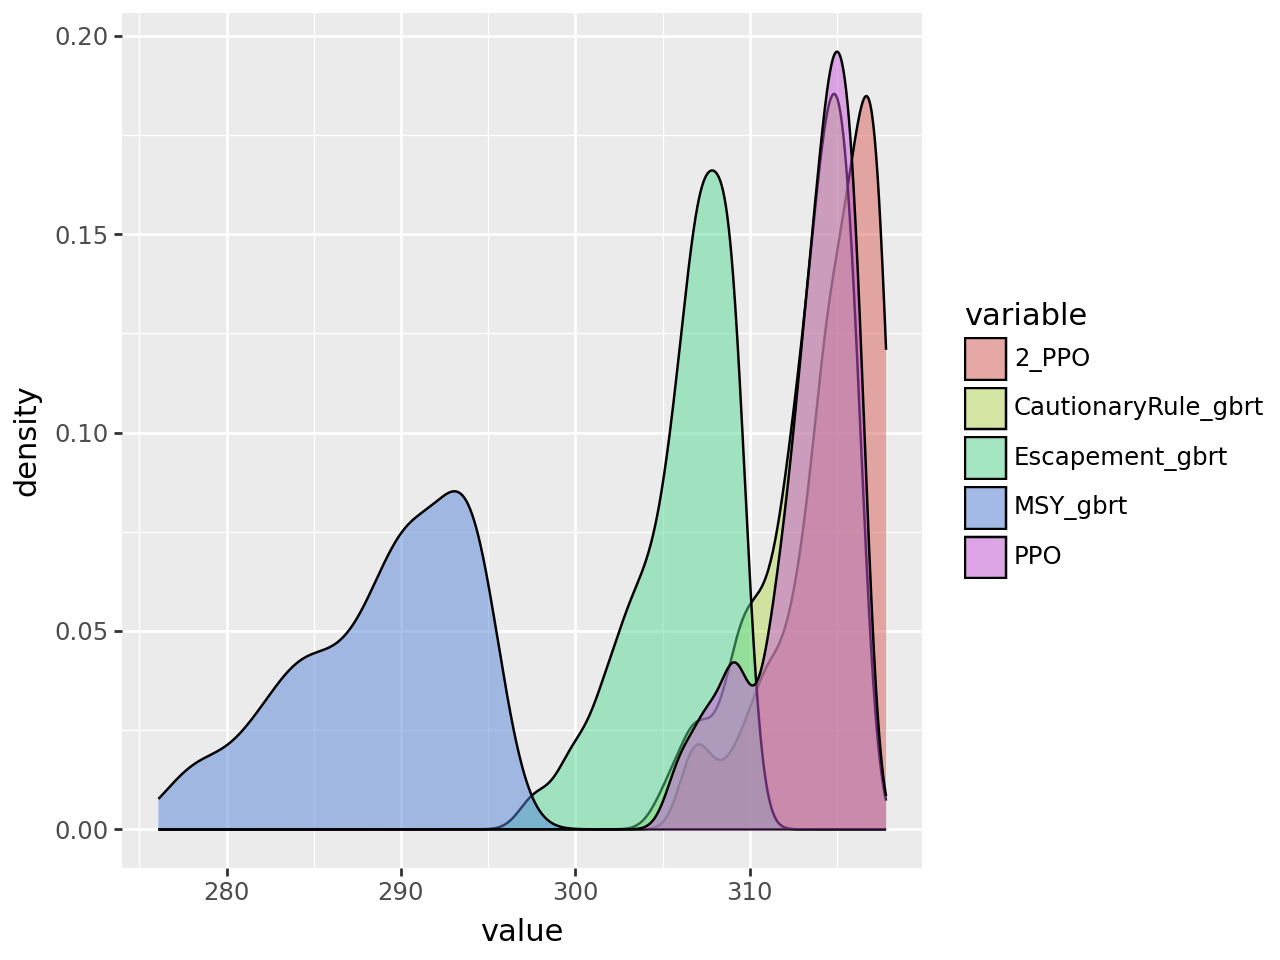

(<Figure Size: (640 x 480)>,)

In [69]:
ggplot(rew_df[(rew_df["optimization"] == 'gbrt') | (rew_df["optimization"] == 'ppo')], aes(x='value', fill='variable')) + geom_density(alpha=0.5),

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


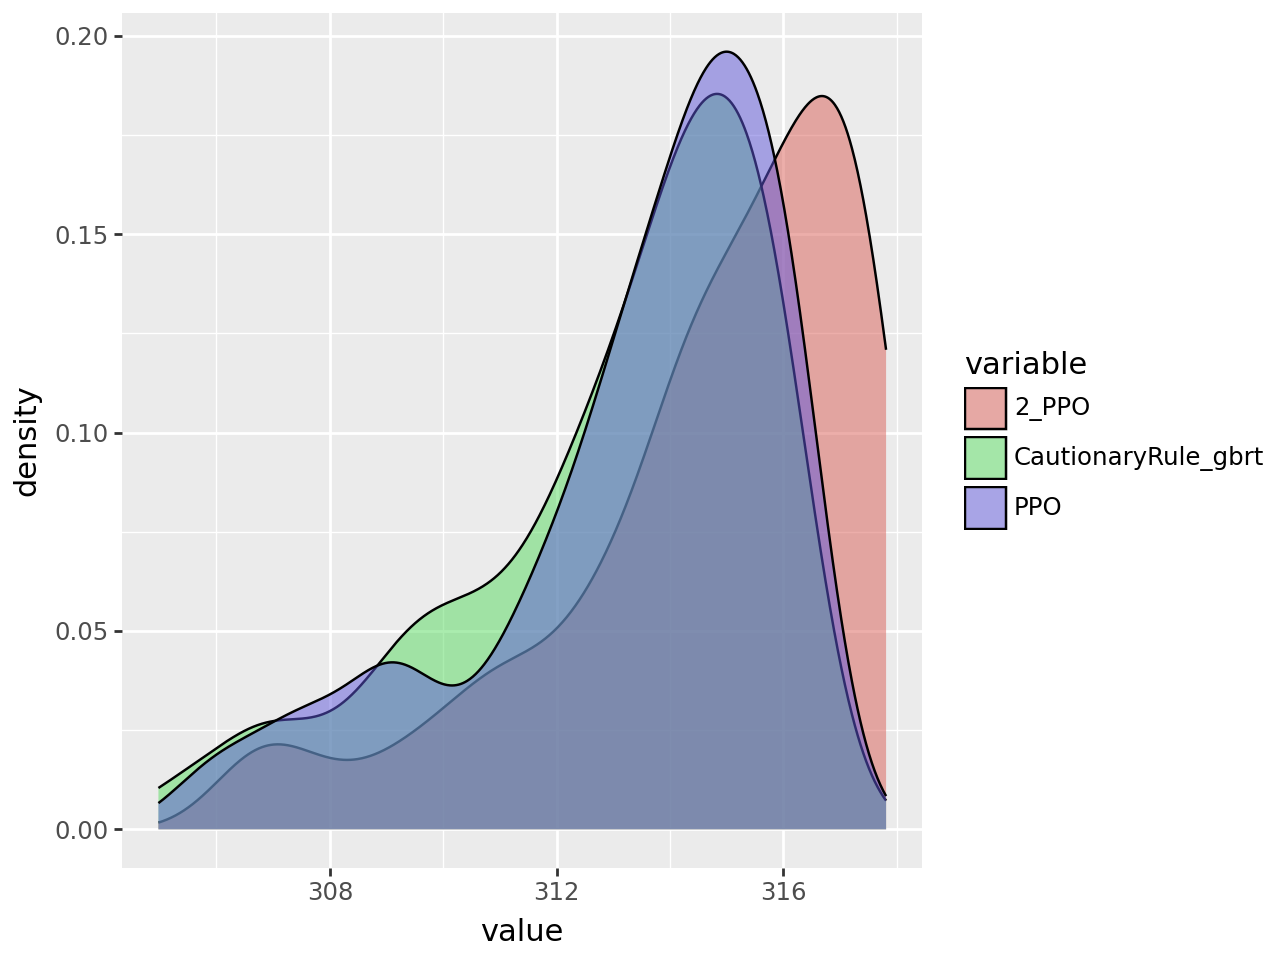

(<Figure Size: (640 x 480)>,)

In [70]:
ggplot(
    rew_df[
        (rew_df["variable"] == "2_PPO")
        | (rew_df["variable"] == "CautionaryRule_gbrt") 
        | (rew_df["variable"] == "PPO")
    ], 
    aes(x='value', fill='variable')
) + geom_density(alpha=0.5),

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


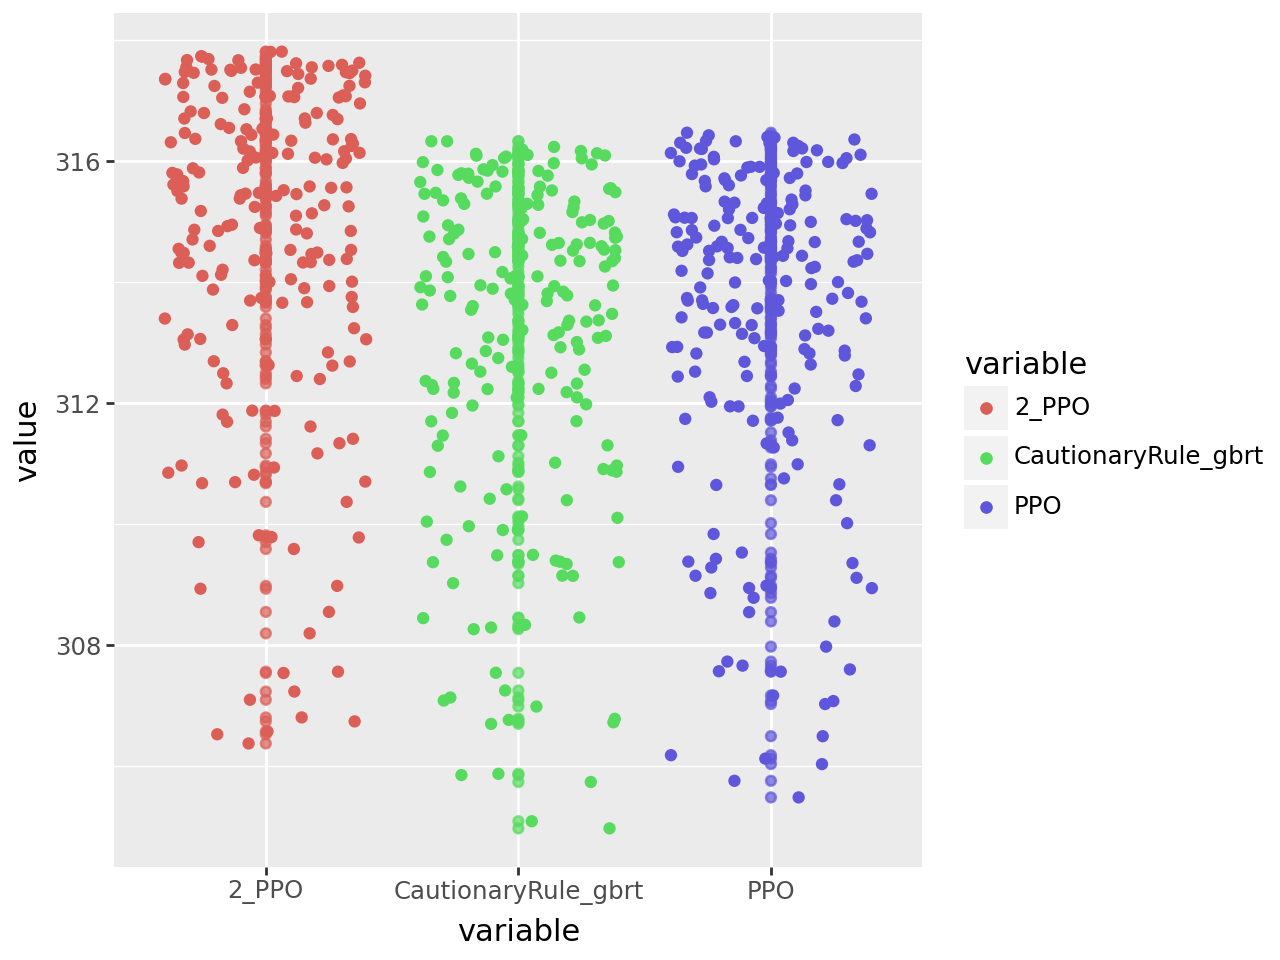

(<Figure Size: (640 x 480)>,)

In [71]:
from plotnine import geom_jitter, geom_point
ggplot(
    rew_df[
        (rew_df["variable"] == "2_PPO")
        | (rew_df["variable"] == "CautionaryRule_gbrt") 
        | (rew_df["variable"] == "PPO")
    ], 
    aes(x='variable', y='value', color='variable')
) + geom_point(alpha=0.7) + geom_jitter(),

# Timeseries

In [28]:
from typing import List, Text, Optional

def simulate_ep(env, agent, other_vars: Optional[List[Text]] = []):   
    simulation = {
        't': [],
        'surv_b_obs': [],
        'mean_wt_obs': [],
        'act': [],
        'rew': [],
        'total_pop': [],
        'newborns': [],
        'non_random_newb': [],
        **{var_name: [] for var_name in other_vars}
    }
    obs, _ = env.reset()
    for t in range(env.Tmax):
        act, _ = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(act)
        #
        simulation['t'].append(t)
        simulation['surv_b_obs'].append(
            env.bound * (obs[0]+1)/2
        )
        simulation['mean_wt_obs'].append(
            (
                env.parameters["min_wt"]
                + (env.parameters["max_wt"] - env.parameters["min_wt"])
                * (obs[1]+1)/2
            )
        )
        simulation['act'].append(act[0])
        simulation['rew'].append(rew)
        simulation['total_pop'].append(np.sum(env.state))
        simulation['newborns'].append(env.state[0])
        simulation['non_random_newb'].append(
            env.parameters["bha"] * env.ssb / (1 + env.parameters["bhb"] * env.ssb)
        )
        for var_name in other_vars:
            simulation[var_name].append(getattr(env, var_name))
        #
        obs = new_obs
    #
    return simulation

In [31]:
from rl4fisheries.envs.asm_fns import get_r_devs

r_devs = get_r_devs(n_year=1000)
config = {'r_devs': r_devs, 's':0.97}

msy_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), msy_gbrt_pol, other_vars=['ssb']))
esc_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), esc_gbrt_pol, other_vars=['ssb']))
cr_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), cr_gbrt_pol, other_vars=['ssb']))
ppo_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), ppoAgent, other_vars=['ssb']))
ppo_2_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), ppoAgent_2, other_vars=['ssb']))

In [32]:
trivp = Msy(env = env, mortality=0)
trivial_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), trivp, other_vars=['ssb']))

In [39]:
import matplotlib.pyplot as plt

## MSY plots

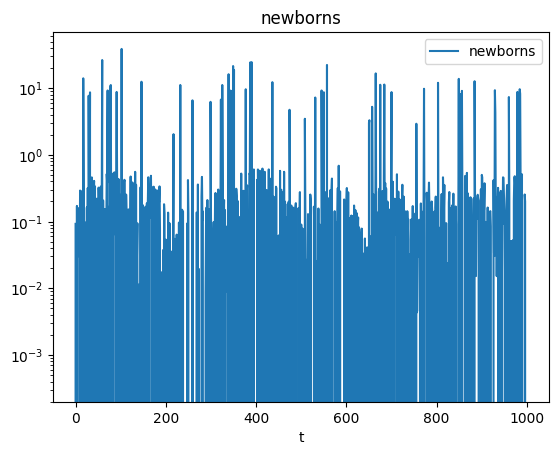

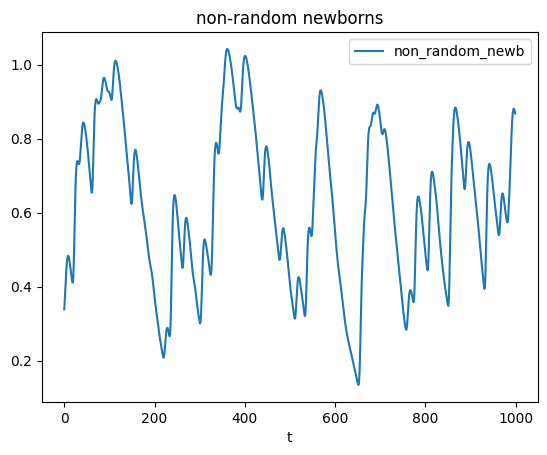

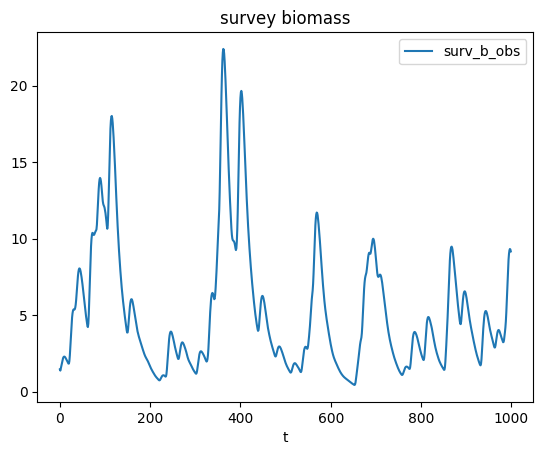

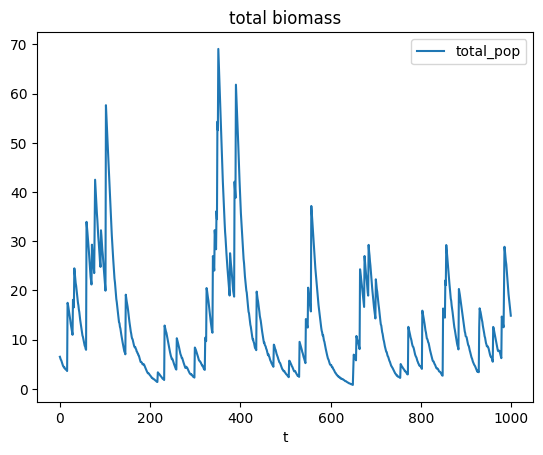

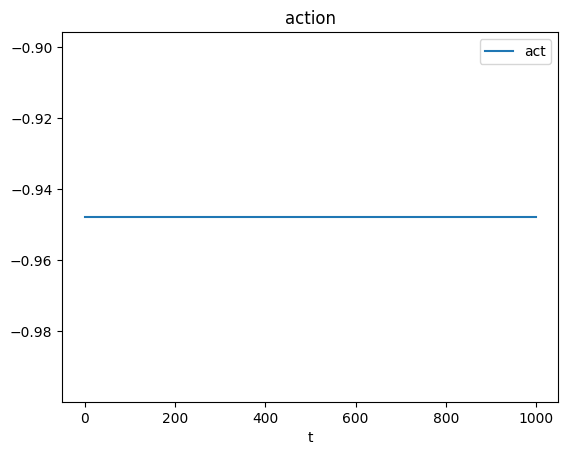

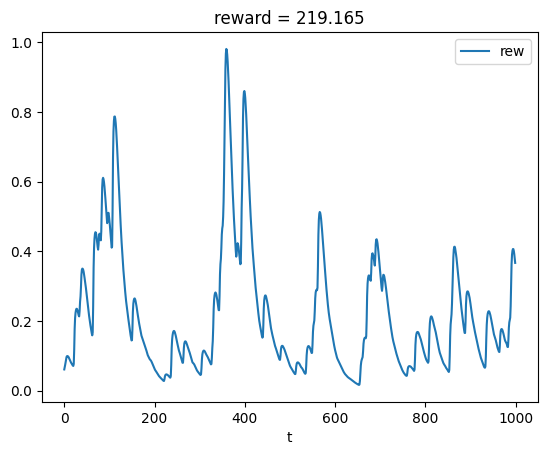

In [42]:
plt.close()
msy_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
msy_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
msy_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
msy_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
msy_ep.plot(x='t', y = ['act'], title='action'),
msy_ep.plot(x='t', y = ['rew'], title=f'reward = {sum(msy_ep.rew):.3f}'),
plt.show()

## Escapement

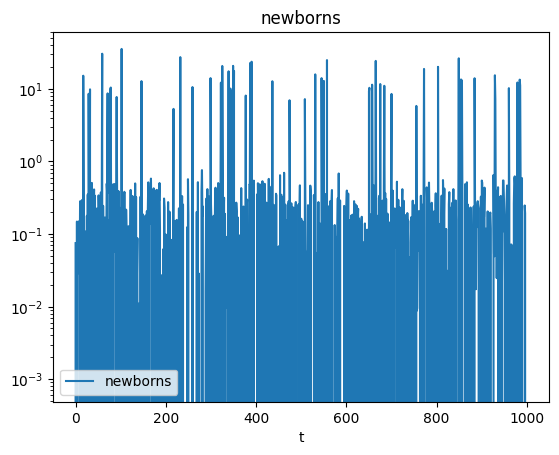

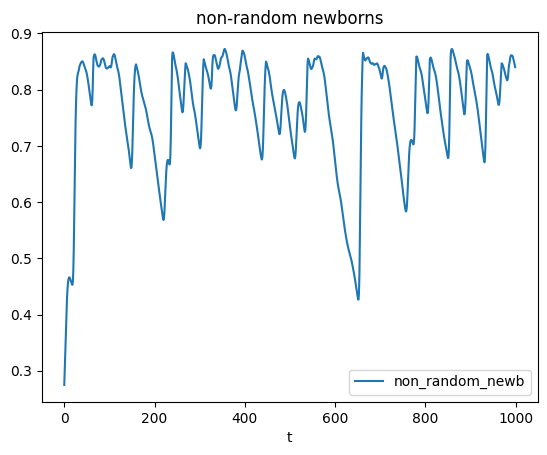

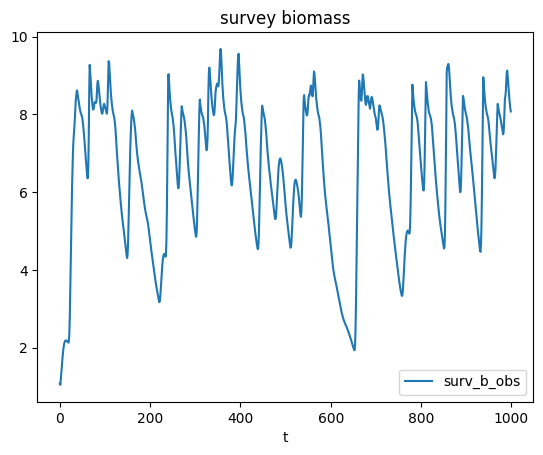

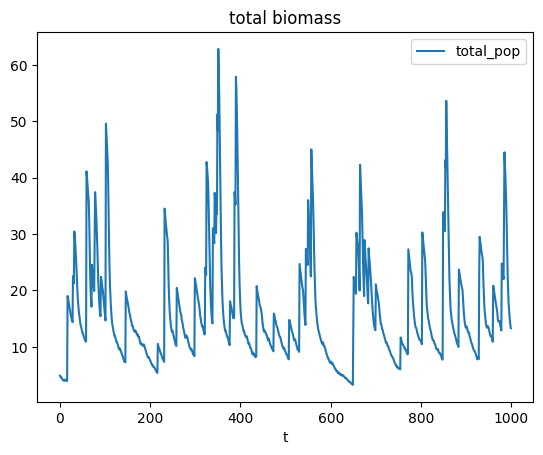

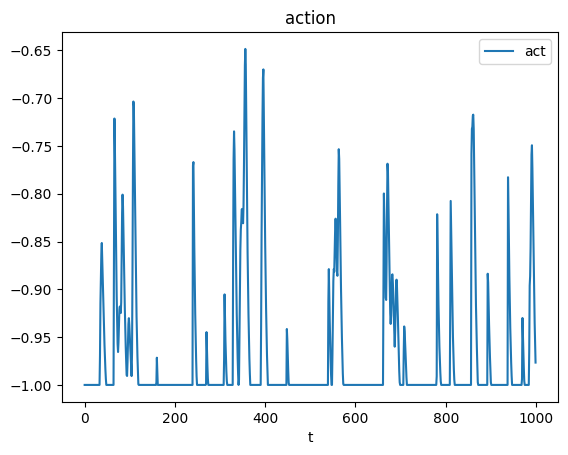

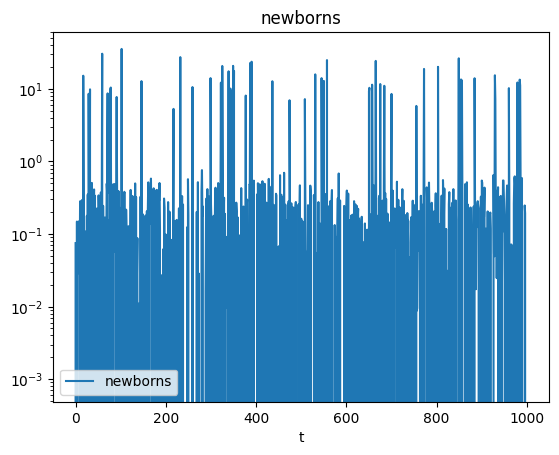

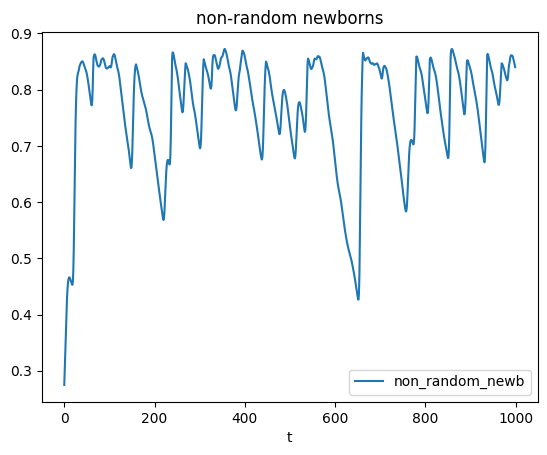

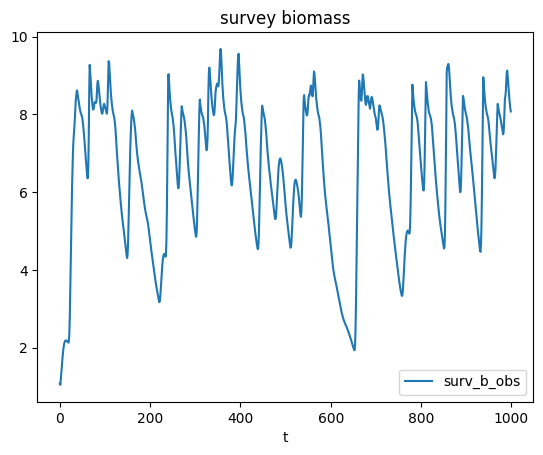

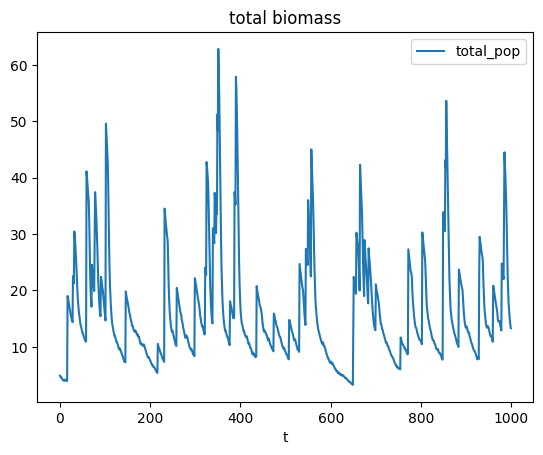

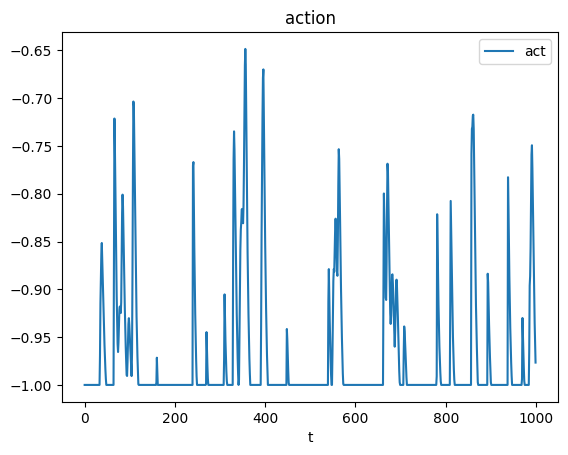

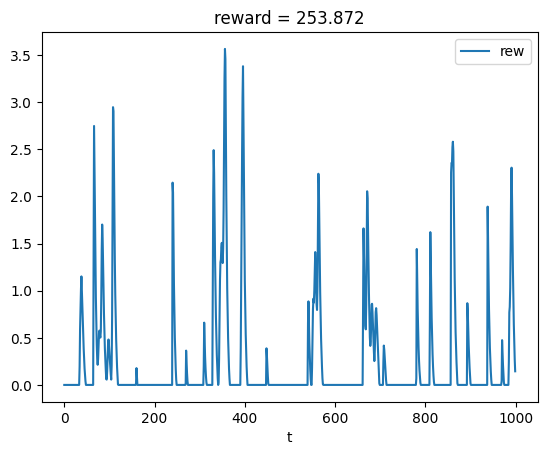

In [44]:
plt.close()
esc_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
esc_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
esc_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
esc_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
esc_ep.plot(x='t', y = ['act'], title='action'),
esc_ep.plot(x='t', y = ['rew'], title = f'reward = {sum(esc_ep.rew):.3f}')
plt.show()

## Cautionary Rule

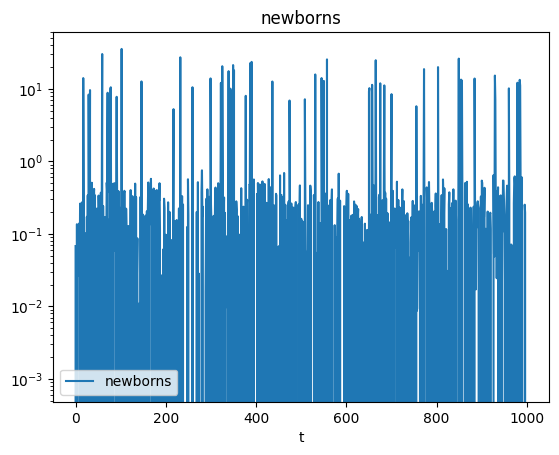

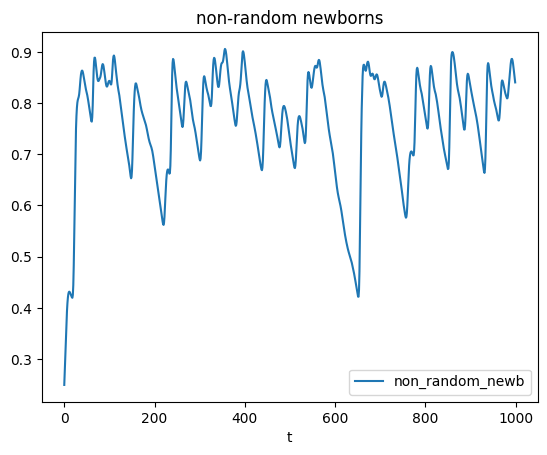

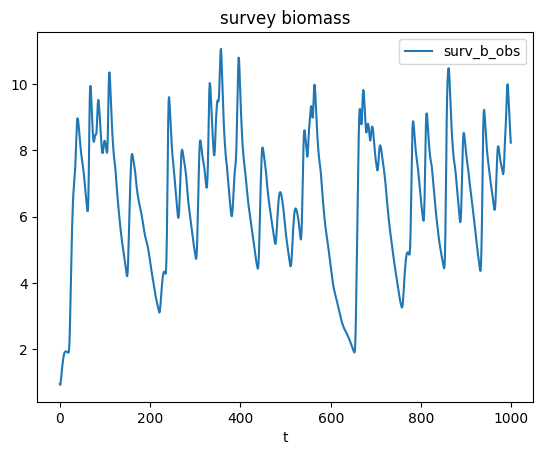

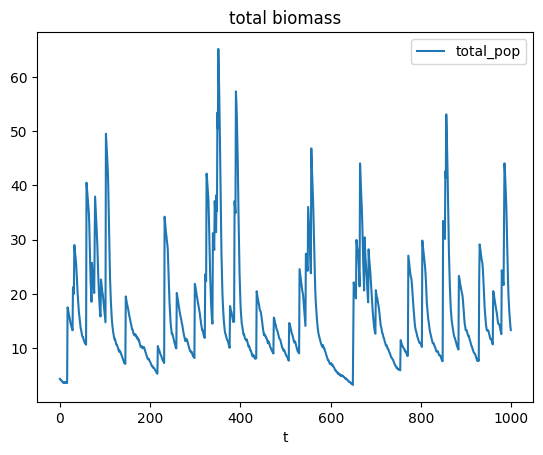

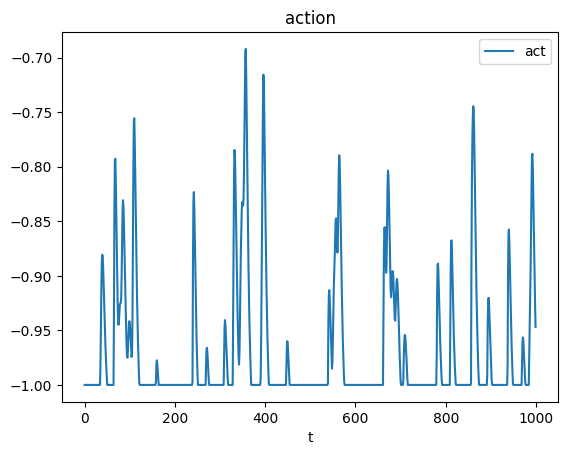

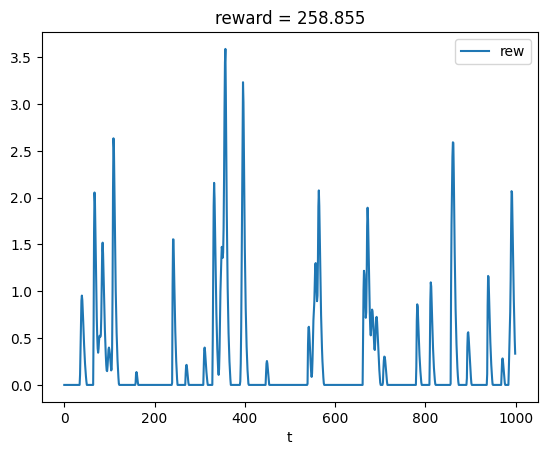

In [45]:
plt.close()
cr_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
cr_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
cr_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
cr_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
cr_ep.plot(x='t', y = ['act'], title='action'),
cr_ep.plot(x='t', y = ['rew'], title=f'reward = {sum(cr_ep.rew):.3f}')
plt.show()

## PPO 2

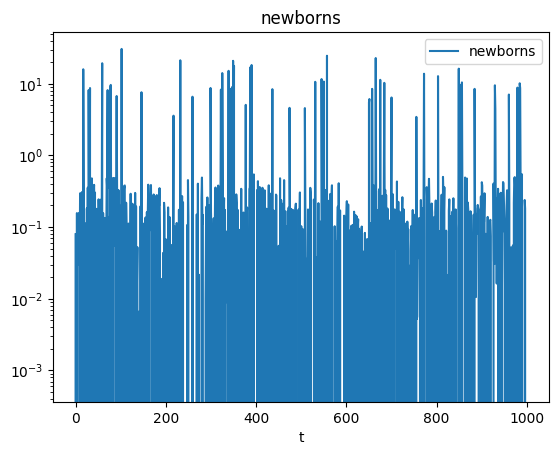

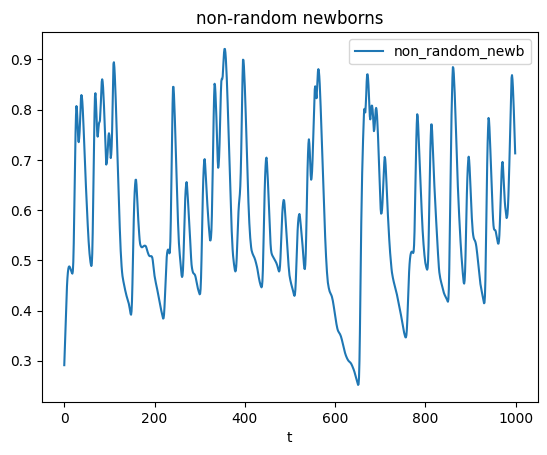

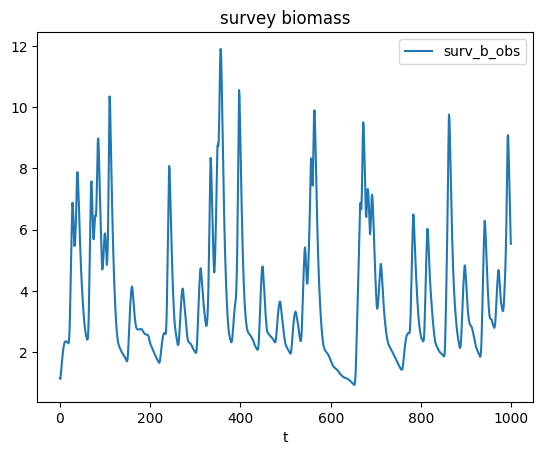

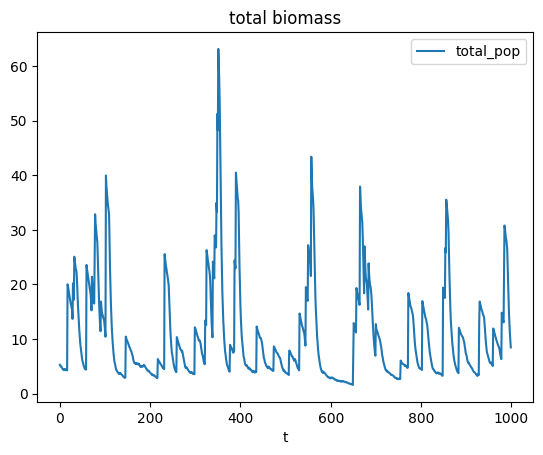

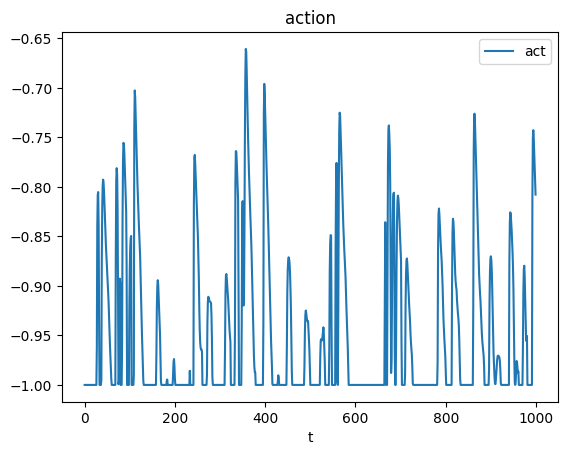

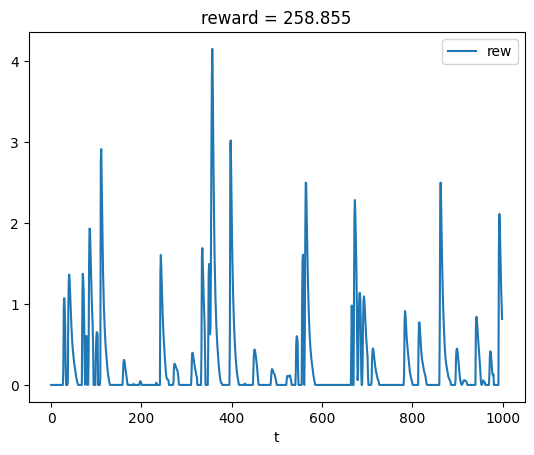

In [46]:
plt.close()
ppo_2_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
ppo_2_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
ppo_2_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
ppo_2_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
ppo_2_ep.plot(x='t', y = ['act'], title='action'),
ppo_2_ep.plot(x='t', y = ['rew'], title=f'reward = {sum(cr_ep.rew):.3f}')
plt.show()

## Trivial (no action)

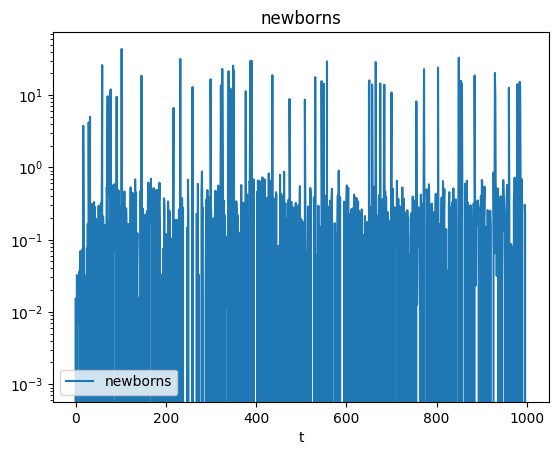

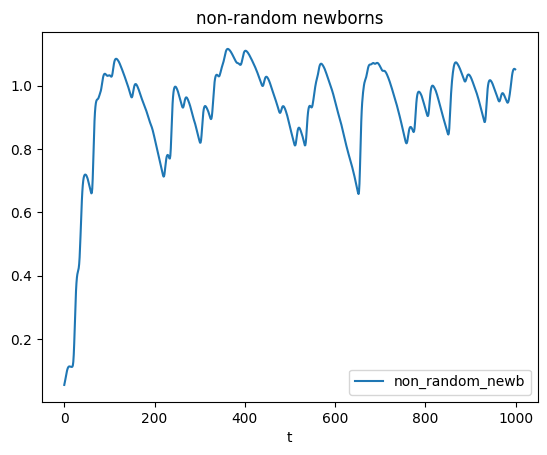

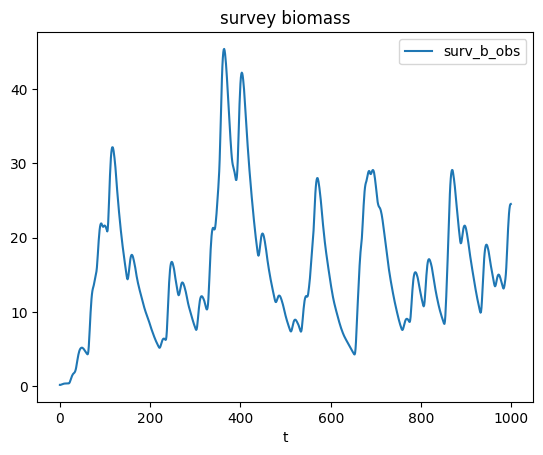

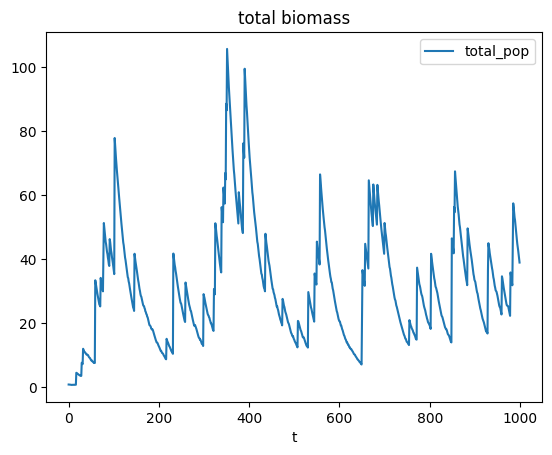

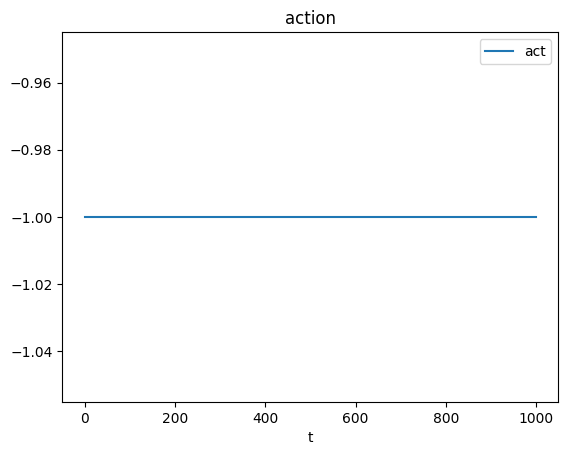

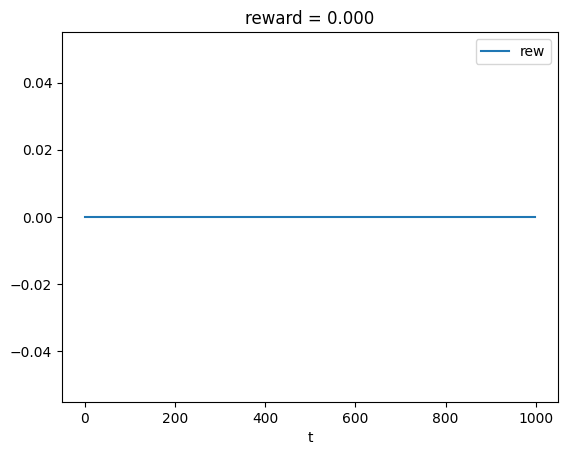

In [49]:
plt.close()
trivial_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
trivial_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
trivial_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
trivial_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
trivial_ep.plot(x='t', y = ['act'], title='action'),
trivial_ep.plot(x='t', y = ['rew'], title=f'reward = {sum(trivial_ep.rew):.3f}')
plt.show()

## Some side by side plots

In [37]:
msy_ep.plot(x='t', y = ['non_random_newb'], title='MSY non-random newborns'),
esc_ep.plot(x='t', y = ['non_random_newb'], title='Esc non-random newborns'),
cr_ep.plot(x='t', y = ['non_random_newb'], title='CR non-random newborns'),
trivial_ep.plot(x='t', y = ['non_random_newb'], title='Unfished non-random newborns'),

(<Axes: title={'center': 'Unfished non-random newborns'}, xlabel='t'>,)

# r_devs

In [50]:
rdev_df = pd.DataFrame({
    't': list(range(len(r_devs))),
    'r_devs': r_devs,
})
rdev_df.plot(x='t', logy=True)

<Axes: xlabel='t'>

In [51]:
(
    len(rdev_df[rdev_df['r_devs']==0]),
    len(rdev_df[(rdev_df['r_devs']>0) & (rdev_df['r_devs']<=1e-1)]),
    len(rdev_df[(rdev_df['r_devs']<=1) & (rdev_df['r_devs']>1e-1)]),
    len(rdev_df[rdev_df['r_devs']>1]),
)

(478, 91, 380, 51)

So about half of the time (n=468/1000) it doesn't actually matter what `ssb` is, since the `r_dev` is just zero.
A bout 10% of the time, it *almost* doesn't matter either, since `r_dev<0.1` in this case.

Having a noise process that is mostly = 1 except for moments of deviation that are fewer in number might make the population dynamics not just reduce itself to the moments in which large schools happen.

Plus, adding some danger around having too-low a population would also potentially make things more interesting.
Currently the `ssb` doesn't really matter in a large percentage of time-steps.
If we fixed the noise to make `ssb` more meaningful, the agent might be more careful about overfishing a large school too early on.
If we add to that a danger of a low population going extinct (e.g. an additive noise term) we might get an agent who will try and keep a high enough `ssb` value at all times, especially during periods that lack large schools.

# What is this reward tail cutoff thing?

To recap, these are some of the reward distribution functions we got out of different policies.

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


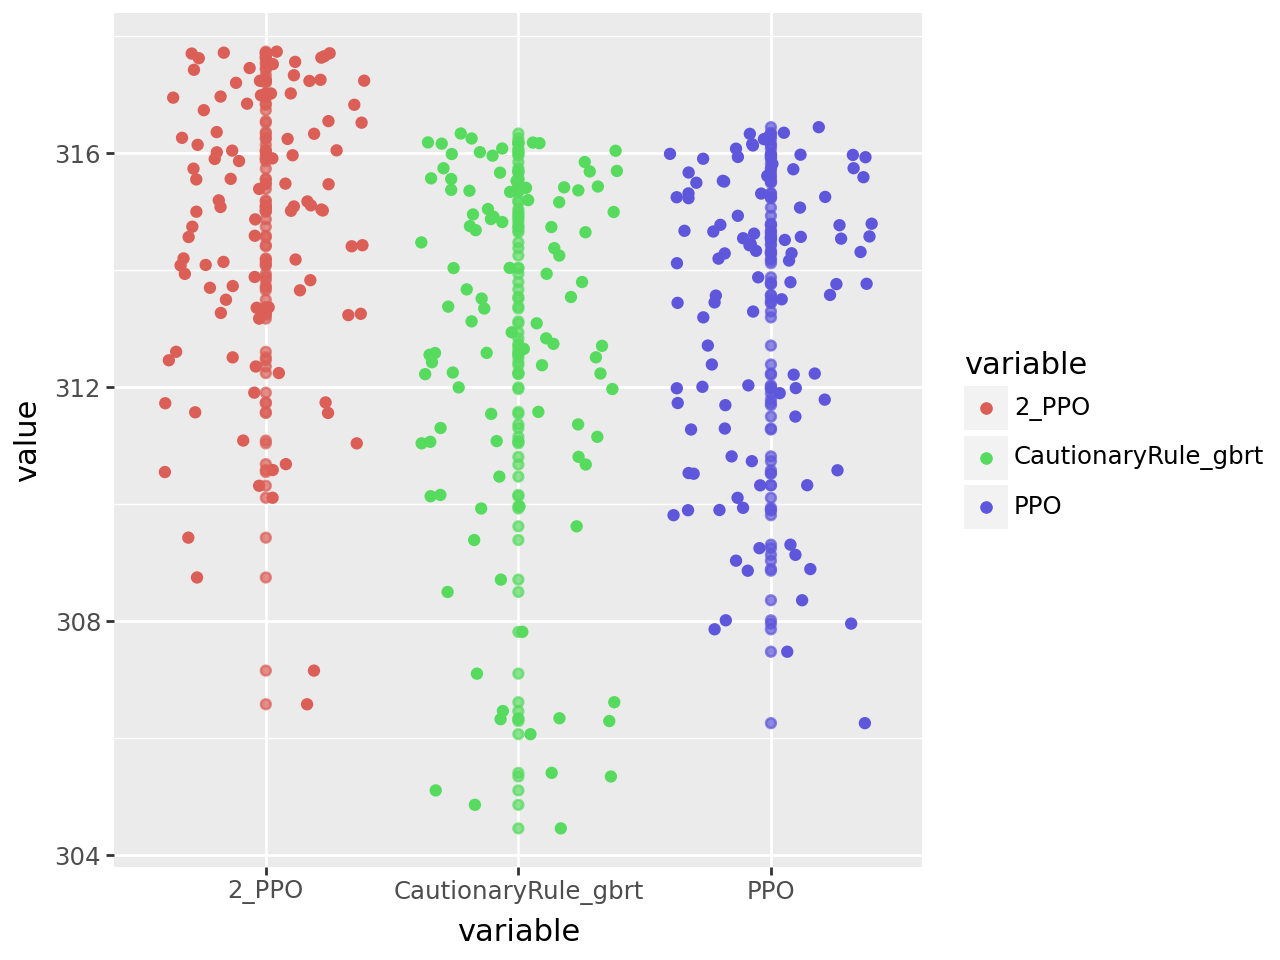

(<Figure Size: (640 x 480)>,)

In [64]:
ggplot(
    rew_df[
        (rew_df["variable"] == "2_PPO")
        | (rew_df["variable"] == "CautionaryRule_gbrt") 
        | (rew_df["variable"] == "PPO")
    ], 
    aes(x='variable', y='value', color='variable')
) + geom_point(alpha=0.7) + geom_jitter(),

Why do they cut off so abruptly near the upper end? In this section I try to explore that.

In [6]:
ppoBoundary_ish = 317.5
crBoundary_ish = 316

In [11]:
import ray
from rl4fisheries.envs.asm_fns import get_r_devs

@ray.remote(num_cpus=0, num_gpus=0.05)
def generate_rew_cuda(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return rew

def best_from_batch(policy, env_cls, batch_size=20):
    tmax = env_cls().Tmax
    configs = [{'s': 0.97, 'r_devs': get_r_devs(tmax)} for _ in range(batch_size)]
    parallel = [generate_rew_cuda.remote(policy, env_cls, config) for config in configs]
    # return parallel
    rews = ray.get(parallel)

    idx = np.argmax(rews)
    print(max(rews), end=" ")
    return configs[idx], rews[idx]




In [ ]:
cfg, rew = best_from_batch(ppoAgent, AsmEnv)


In [145]:
evaluate_policy(cr_gbrt_pol, env=Monitor(AsmEnv({'s':0.97})), return_episode_rewards=True)

([0.459517,
  0.462409,
  0.452862,
  0.460016,
  0.455386,
  0.456048,
  0.460467,
  0.458816,
  0.457718,
  0.461759],
 [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [116]:
@ray.remote(num_gpus=1)
def f(arg):
    arg.predict([0,0])
    return torch.cuda.is_available(), arg

ray.get([f.remote(ppoAgent) for _ in range(2)])

[(True, <stable_baselines3.ppo.ppo.PPO at 0x7fe3c82f90c0>),
 (True, <stable_baselines3.ppo.ppo.PPO at 0x7fe1f5d16290>)]